In [241]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from gensim import models
from konlpy.tag import Mecab
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, cross_validate
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import SGDClassifier

# Data Loading

In [109]:
ko_model = models.fasttext.load_facebook_model('/home/fakenews/advanced_ml/src/fasttext_wiki/wiki.ko.bin')
mecab = Mecab()

In [110]:
labels = ['taste','delivery','quantity']

In [111]:
def get_datas(): #데이터 불러오기
    datas = dict()
    for label in labels:
        train_df = pd.read_csv(f"dataset/1119/train_{label}.csv")
        test_df = pd.read_csv(f"dataset/1119/test_{label}.csv")
        datas[label] = (train_df,test_df)
    return datas

In [112]:
def get_vector_label(datas):
    vector_label_pairs = dict()

    # Get Train Vectors
    for label in labels:
        dfs = datas[label]
        train_df, test_df = dfs
        train_vectors = []
        for i in tqdm(range(train_df.shape[0])):
            vc = np.zeros((300))
            pos_list = mecab.pos(train_df['text'].iloc[i])
            for pos in pos_list:
                vc = vc + ko_model.wv.word_vec(pos[0])
            vc = vc/len(pos_list)
            train_vectors.append(vc)
        X_train_fastetext_emb = np.array(train_vectors)
        train_label = train_df[label]

        # Get Test Vectors
        test_vectors = []
        for i in tqdm(range(test_df.shape[0])):
            vc = np.zeros((300))
            pos_list = mecab.pos(test_df['text'].iloc[i])
            for pos in pos_list:
                vc = vc + ko_model.wv.word_vec(pos[0])
            vc = vc/len(pos_list)
            test_vectors.append(vc)
        X_test_fastetext_emb = np.array(test_vectors)
        test_label = test_df[label]

        vector_label_pairs[label] = ((X_train_fastetext_emb,train_label),(X_test_fastetext_emb,test_label))
    return vector_label_pairs

In [113]:
datas = get_datas()

In [117]:
vector_label = get_vector_label(datas)

100%|██████████| 2612/2612 [00:00<00:00, 3367.46it/s]


# ML

XGBoost, Random Forest, SGD Classifier 를 사용하여 실험을 진행

## XGBoost

전체 sample을 5로 예측했을 때 보다 정확도가 소폭 증가했으며, 다른 두 모델에 비해 각 카테고리별 별점을 5로 치우쳐진 예측을 하는 경향성이 떨어졌다.

In [92]:
#random search를 사용하여 파라미터 튜닝을 마친 모델 딕셔너리로 저장
xgb_best_models = dict() 
for label in labels:
    train_tup, test_tup = vector_label[label]
    x_train, y_train = train_tup
    x_test, y_test = test_tup
    xgb = XGBClassifier()
    xgb_params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
    }
    
    rnd_search = RandomizedSearchCV(xgb, param_distributions=xgb_params, n_iter=5,
                                   scoring='accuracy', n_jobs=4, verbose=3, random_state=42)
    rnd_search.fit(x_train, y_train)
    best_xgb = rnd_search.best_estimator_
    best_xgb.fit(x_train,y_train)
    xgb_best_models[label] = best_xgb

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/home/fakenews/anaconda3/envs/fakenews/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:01:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:02:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting 5 folds for each of 5 candidates, totalling 25 fits


/home/fakenews/anaconda3/envs/fakenews/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:13:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:13:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting 5 folds for each of 5 candidates, totalling 25 fits


/home/fakenews/anaconda3/envs/fakenews/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:21:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:22:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


### taste

In [206]:
train_tup, test_tup = vector_label['taste']
x_train, y_train = train_tup
x_test, y_test = test_tup

In [253]:
xgb_taste = xgb_best_models['taste']
train_taste,test_taste = datas['taste']
y_pred_taste = xgb_taste.predict(x_test)


In [209]:
test_taste_score = test_taste['taste']

In [211]:
#precision, recall f-score 확인
print(classification_report(test_taste_score, y_pred_taste, target_names=("1", "2", "3", "4", "5")))
test_taste['xgb_taste_pred'] = y_pred_taste 

              precision    recall  f1-score   support

           1       0.42      0.12      0.19        89
           2       0.25      0.01      0.03        73
           3       0.47      0.05      0.09       288
           4       0.46      0.02      0.04      1186
           5       0.87      1.00      0.93     10120

    accuracy                           0.86     11756
   macro avg       0.49      0.24      0.25     11756
weighted avg       0.81      0.86      0.81     11756



#### 실제 별점과는 다르지만 텍스트 기반으로 별점을 예측한 결과

'맛'

실제 : 3 - Pred : 1 - Text : 햄버거가 .. 점점 맛이 없어져요.

실제 : 4 - Pred : 5 - Text : 처음 먹어봤는데 맛있어요!

In [ ]:
for i in range(test_taste.shape[0]):
	if(test_taste['xgb_taste_pred'][i]!=5):
		print(f"Label : {test_taste['taste'][i]} - Pred : {test_taste['xgb_taste_pred'][i]} - Text : {test_taste['text'][i]}")

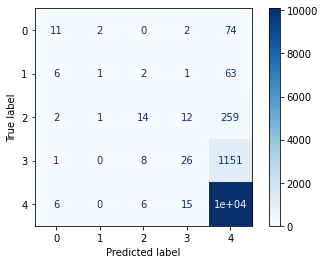

In [234]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(test_taste_score,y_pred_taste))
disp.plot(cmap='Blues')

### quantity

In [170]:
train_tup_quan, test_tup_quan = vector_label['quantity']
x_train_quan, y_train_quan = train_tup_quan
x_test_quan, y_test_quan = test_tup_quan

In [172]:
xgb_quantity = xgb_best_models['quantity']
train_quantity,test_quantity = datas['quantity']
y_pred_quantity = xgb_quantity.predict(x_test_quan)


In [174]:
test_quantity_score = test_quantity['quantity']

In [175]:
#precision, recall f-score 확인
print(classification_report(test_quantity_score, y_pred_quantity, target_names=("1", "2", "3", "4", "5")))
test_quantity['xgb_quantity_pred'] = y_pred_quantity 

              precision    recall  f1-score   support

           1       0.69      0.29      0.41        38
           2       0.14      0.02      0.04        46
           3       0.47      0.26      0.33       134
           4       0.35      0.08      0.13       268
           5       0.85      0.98      0.91      2126

    accuracy                           0.83      2612
   macro avg       0.50      0.33      0.36      2612
weighted avg       0.77      0.83      0.78      2612



#### 실제 별점과는 다르지만 텍스트 기반으로 별점을 예측한 결과

'양'

실제 : 2 - Pred : 3 - Text : 맛은 그럭저럭. 양은 흐으음...... 배달은 빠름.

실제 : 4 - Pred : 3 - Text : 프라이드는 역시 이집인 듯 요ㅎ양이 살짝 적은 거 같지만 잘 먹겠습니다

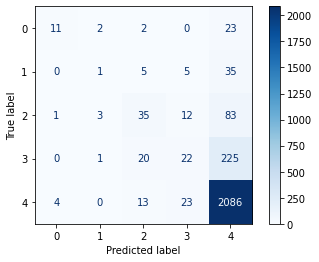

In [235]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(test_quantity_score,y_pred_quantity))
disp.plot(cmap='Blues')

### delivery

In [178]:
train_tup_deliv, test_tup_deliv = vector_label['delivery']
x_train_deliv, y_train_deliv = train_tup_deliv
x_test_deliv, y_test_deliv = test_tup_deliv

In [179]:
xgb_delivery = xgb_best_models['delivery']
train_delivery,test_delivery = datas['delivery']
y_pred_delivery = xgb_delivery.predict(x_test_deliv)


In [182]:
test_delivery_score = test_delivery['delivery']

In [184]:
#precision, recall f-score 확인
print(classification_report(test_delivery_score, y_pred_delivery, target_names=("1", "2", "3", "4", "5")))
test_delivery['xgb_delivery_pred'] = y_pred_delivery

              precision    recall  f1-score   support

           1       0.64      0.57      0.60       167
           2       0.31      0.08      0.13        62
           3       0.45      0.17      0.25       143
           4       0.31      0.06      0.10       278
           5       0.86      0.98      0.92      2673

    accuracy                           0.83      3323
   macro avg       0.52      0.38      0.40      3323
weighted avg       0.78      0.83      0.79      3323



#### 실제 별점과는 다르지만 텍스트 기반으로 별점을 예측한 결과

'배달'

실제 : 3 - Pred : 1 - Text : 배달시간 오래 걸리는 거 빼곤 조음

실제 : 4 - Pred : 1 - Text : 배달.. 너무 오래 걸리네요

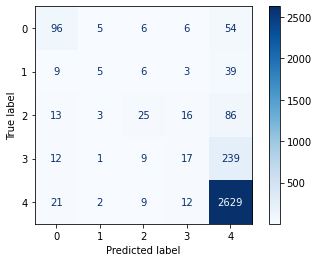

In [236]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(test_delivery_score,y_pred_delivery))
disp.plot(cmap='Blues')

## Random Forest

In [1]:
rf_best_models = dict() #random search를 사용하여 파라미터 튜닝을 마친 모델 딕셔너리로 저장
for label in labels:
    train_tup, test_tup = vector_label[label]
    x_train, y_train = train_tup
    x_test, y_test = test_tup
    rf_clf = RandomForestClassifier()
    rf_params = { 'n_estimators' : [10, 30, 50],
           'max_depth' : [2, 4, 6, 8],
           'max_features' : [2, 4, 6, 8],
           'min_samples_leaf' : [12, 18, 24],
           'min_samples_split' : [8, 16, 20]
    }

    randomized_search = RandomizedSearchCV(rf_clf, param_distributions=rf_params, n_iter=5, return_train_score=True, scoring='accuracy', cv=5) 
    randomized_search.fit(x_train, y_train)
    best_rf = randomized_search.best_estimator_
    best_rf.fit(x_train,y_train)
    rf_best_models[label] = best_rf
    

NameError: name 'labels' is not defined

Random Forest는 거의 대부분을 5로 예측하는 경향성이 있음

### taste

In [254]:
train_tup, test_tup = vector_label['taste']
x_train, y_train = train_tup
x_test, y_test = test_tup

In [255]:
rf_best_models['taste']

RandomForestClassifier(max_depth=4, max_features=6, min_samples_leaf=18,
                       min_samples_split=8, n_estimators=10)

In [256]:
rf_taste = rf_best_models['taste']
y_pred_rf_taste = rf_taste.predict(x_test)


In [261]:
print(classification_report(test_taste_score, y_pred_rf_taste, target_names=("1", "2", "3", "4", "5")))
test_taste['rf_taste_pred'] = y_pred_rf_taste


              precision    recall  f1-score   support

           1       0.00      0.00      0.00        89
           2       0.00      0.00      0.00        73
           3       0.00      0.00      0.00       288
           4       0.00      0.00      0.00      1186
           5       0.86      1.00      0.93     10120

    accuracy                           0.86     11756
   macro avg       0.17      0.20      0.19     11756
weighted avg       0.74      0.86      0.80     11756



/home/fakenews/anaconda3/envs/fakenews/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/fakenews/anaconda3/envs/fakenews/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/fakenews/anaconda3/envs/fakenews/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

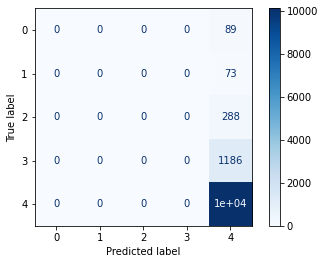

In [296]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(test_taste_score,y_pred_rf_taste))
disp.plot(cmap='Blues')

### quantity

In [264]:
rf_best_models['quantity']
rf_quantity = rf_best_models['quantity']
y_pred_rf_quantity = rf_quantity.predict(x_test_quan)

In [267]:
print(classification_report(test_quantity_score, y_pred_rf_quantity, target_names=("1", "2", "3", "4", "5")))
test_quantity['rf_quantity_pred'] = y_pred_rf_quantity

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        38
           2       0.00      0.00      0.00        46
           3       1.00      0.01      0.03       134
           4       0.00      0.00      0.00       268
           5       0.81      1.00      0.90      2126

    accuracy                           0.81      2612
   macro avg       0.36      0.20      0.19      2612
weighted avg       0.71      0.81      0.73      2612



/home/fakenews/anaconda3/envs/fakenews/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/fakenews/anaconda3/envs/fakenews/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/fakenews/anaconda3/envs/fakenews/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

#### 실제 별점과는 다르지만 텍스트 기반으로 별점을 예측한 결과

'양'

Label : 3 - Pred : 4 - Text : 양이 좀 적은 것 빼곤 괜찮아요~~~^^

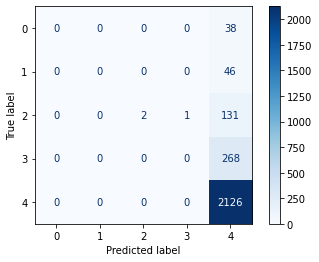

In [298]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(test_quantity_score,y_pred_sgd_quantity))
disp.plot(cmap='Blues')

### delivery
        

In [270]:
rf_best_models['delivery']
rf_delivery = rf_best_models['delivery']
y_pred_rf_delivery = rf_delivery.predict(x_test_deliv)

In [273]:
print(classification_report(test_delivery_score, y_pred_rf_delivery, target_names=("1", "2", "3", "4", "5")))
test_delivery['rf_delivery_pred'] = y_pred_rf_delivery

              precision    recall  f1-score   support

           1       1.00      0.03      0.06       167
           2       0.00      0.00      0.00        62
           3       0.00      0.00      0.00       143
           4       0.00      0.00      0.00       278
           5       0.81      1.00      0.89      2673

    accuracy                           0.81      3323
   macro avg       0.36      0.21      0.19      3323
weighted avg       0.70      0.81      0.72      3323



/home/fakenews/anaconda3/envs/fakenews/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/fakenews/anaconda3/envs/fakenews/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/fakenews/anaconda3/envs/fakenews/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

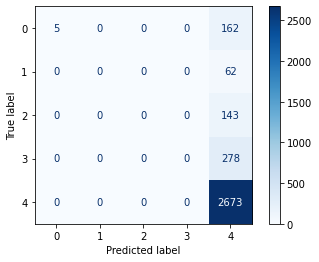

In [275]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(test_delivery_score,y_pred_rf_delivery))
disp.plot(cmap='Blues')

## SGD Classifier

In [302]:
#random search를 사용하여 파라미터 튜닝을 마친 모델 딕셔너리로 저장
sgd_best_models = dict() 
for label in labels:
    train_tup, test_tup = vector_label[label]
    x_train, y_train = train_tup
    x_test, y_test = test_tup
    sgd_clf = SGDClassifier(max_iter=30, random_state=42)
    sgd_params = {'average': [True, False], 'l1_ratio': np.linspace(0, 1, num=10), 'alpha': np.power(10, np.arange(-4, 1, dtype=float))}

    randomized_search_sgd = RandomizedSearchCV(sgd_clf, param_distributions=sgd_params, n_iter=5, scoring='accuracy', cv=5) 
    randomized_search_sgd.fit(x_train, y_train)
    best_sgd = randomized_search_sgd.best_estimator_
    best_sgd.fit(x_train,y_train)
    sgd_best_models[label] = best_sgd
    

/home/fakenews/anaconda3/envs/fakenews/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/home/fakenews/anaconda3/envs/fakenews/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/home/fakenews/anaconda3/envs/fakenews/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/home/fakenews/anaconda3/envs/fakenews/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increa

### taste

In [327]:
train_tup, test_tup = vector_label['taste']
x_train, y_train = train_tup
x_test, y_test = test_tup

In [328]:
sgd_best_models['taste']

SGDClassifier(alpha=0.1, average=True, l1_ratio=0.1111111111111111, max_iter=30,
              random_state=42)

In [329]:
sgd_taste = sgd_best_models['taste']
y_pred_sgd_taste = sgd_taste.predict(x_test)


In [330]:
print(classification_report(test_taste_score, y_pred_sgd_taste, target_names=("1", "2", "3", "4", "5")))
test_taste['sgd_taste_pred'] = y_pred_sgd_taste


              precision    recall  f1-score   support

           1       0.00      0.00      0.00        89
           2       0.00      0.00      0.00        73
           3       0.00      0.00      0.00       288
           4       0.00      0.00      0.00      1186
           5       0.86      1.00      0.93     10120

    accuracy                           0.86     11756
   macro avg       0.17      0.20      0.19     11756
weighted avg       0.74      0.86      0.80     11756



/home/fakenews/anaconda3/envs/fakenews/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/fakenews/anaconda3/envs/fakenews/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/fakenews/anaconda3/envs/fakenews/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

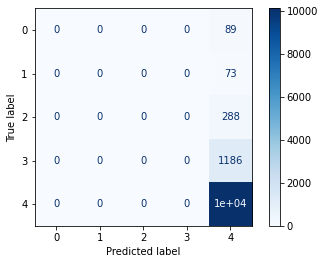

In [308]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(test_taste_score,y_pred_sgd_taste))
disp.plot(cmap='Blues')

### quantity

In [309]:
sgd_quantity = sgd_best_models['quantity']
y_pred_sgd_quantity = sgd_quantity.predict(x_test_quan)


In [312]:
print(classification_report(test_quantity_score, y_pred_sgd_quantity, target_names=("1", "2", "3", "4", "5")))
test_quantity['sgd_quantity_pred'] = y_pred_sgd_quantity


              precision    recall  f1-score   support

           1       0.00      0.00      0.00        38
           2       0.00      0.00      0.00        46
           3       0.35      0.18      0.24       134
           4       1.00      0.00      0.01       268
           5       0.83      0.99      0.91      2126

    accuracy                           0.82      2612
   macro avg       0.44      0.24      0.23      2612
weighted avg       0.80      0.82      0.75      2612



/home/fakenews/anaconda3/envs/fakenews/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/fakenews/anaconda3/envs/fakenews/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/fakenews/anaconda3/envs/fakenews/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

#### 실제 별점과는 다르지만 텍스트 기반으로 별점을 예측한 결과

'양'

Label : 4 - Pred : 3 - Text : 생각보다 양이 적습니다. 맛은 맛있네요ㅎ

Label : 2 - Pred : 3 - Text : 맛은 있는데 양이 좀 적네요

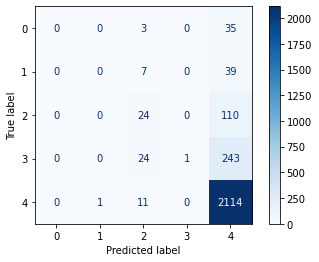

In [314]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(test_quantity_score,y_pred_sgd_quantity))
disp.plot(cmap='Blues')

### delivery

In [316]:
sgd_delivery = sgd_best_models['delivery']
y_pred_sgd_delivery = sgd_delivery.predict(x_test_deliv)


In [317]:
print(classification_report(test_delivery_score, y_pred_sgd_delivery, target_names=("1", "2", "3", "4", "5")))
test_delivery['sgd_delivery_pred'] = y_pred_sgd_delivery


              precision    recall  f1-score   support

           1       0.62      0.47      0.53       167
           2       0.00      0.00      0.00        62
           3       0.42      0.08      0.13       143
           4       0.00      0.00      0.00       278
           5       0.84      1.00      0.91      2673

    accuracy                           0.83      3323
   macro avg       0.38      0.31      0.32      3323
weighted avg       0.72      0.83      0.77      3323



/home/fakenews/anaconda3/envs/fakenews/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/fakenews/anaconda3/envs/fakenews/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/fakenews/anaconda3/envs/fakenews/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

#### 실제 별점과는 다르지만 텍스트 기반으로 별점을 예측한 결과

'배달'

Label : 4 - Pred : 1 - Text : 배달,, 너무 오래 걸리네요 ㅠㅠ

Label : 4 - Pred : 1 - Text : 배달 예상시간 30분인데 한 시간 걸려서 오셨고 버거는 다 식었네요.

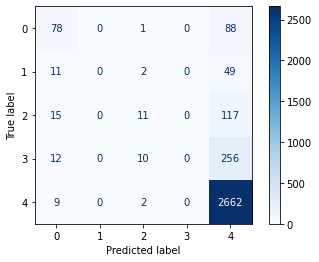

In [323]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(test_delivery_score,y_pred_sgd_delivery))
disp.plot(cmap='Blues')